### A. Import dữ liệu cần thiết

In [142]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import re

pd.options.display.float_format = '{:,.0f}'.format
# pd.options.display.float_format = None

In [143]:
trending_videos = pd.read_csv('Data/trending_videos.csv')
trending_videos['snapshot_date'] = pd.to_datetime(trending_videos['snapshot_date'])
trending_videos['published_at'] = pd.to_datetime(trending_videos['published_at'])
trending_videos['duration'] = pd.to_timedelta(trending_videos['duration']).dt.total_seconds()

### B. Trực quan hoá

#### 1. Phân tích tổng quan

##### a. Thời điểm đăng trong ngày của video

In [144]:
trending_videos_hours = trending_videos['published_at'].dt.hour

<Axes: >

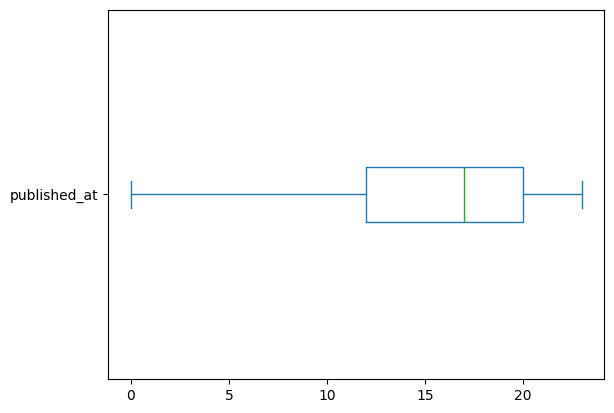

In [145]:
trending_videos_hours.plot(kind='box',vert=False)

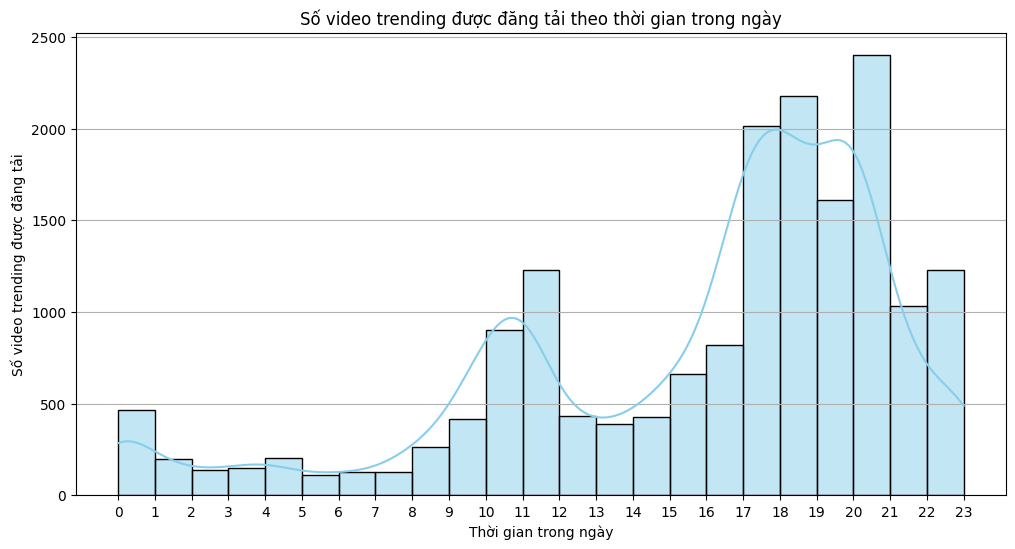

In [146]:
trending_videos_hours = trending_videos['published_at'].dt.hour
plt.figure(figsize=(12, 6))
sns.histplot(trending_videos_hours, bins=23, kde=True, color='skyblue')
plt.xlabel('Thời gian trong ngày')
plt.ylabel('Số video trending được đăng tải')
plt.title('Số video trending được đăng tải theo thời gian trong ngày')
plt.xticks(range(24))
plt.grid(True, axis='y')
plt.show()

##### b. Thời gian tồn tại trên trending

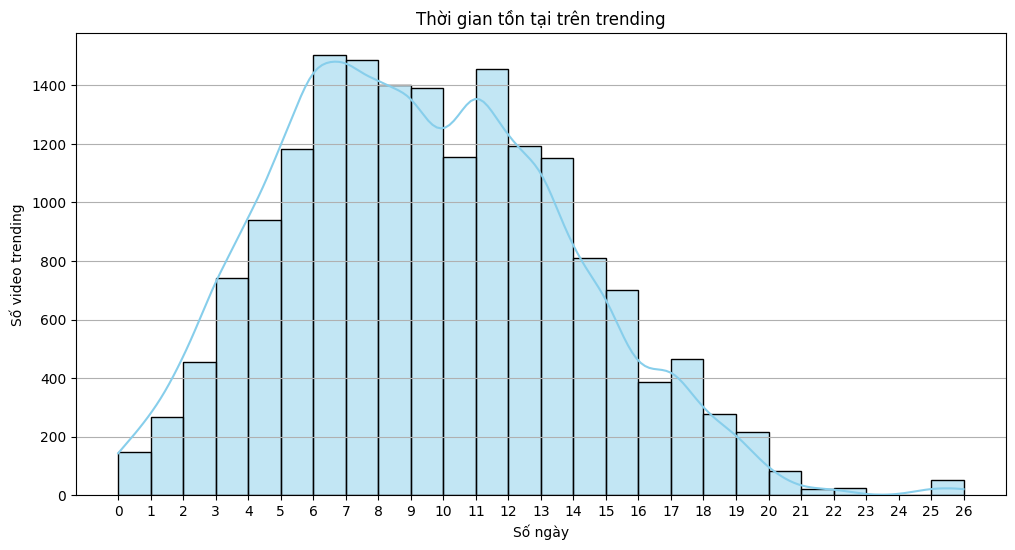

In [147]:
trending_duration = trending_videos.groupby('video_id')['snapshot_date'].transform(lambda x: (x.max() - x.min()).days)
plt.figure(figsize=(12, 6))
sns.histplot(trending_duration, bins=range(trending_duration.max() + 1), kde=True, color='skyblue')
plt.xlabel('Số ngày')
plt.xticks(range(27))
plt.ylabel('Số video trending')
plt.title('Thời gian tồn tại trên trending')
plt.grid(True, axis='y')
plt.show()

#### 2. Phân tích theo chủ đề

##### a. Độ dài trung bình của video theo chủ đề

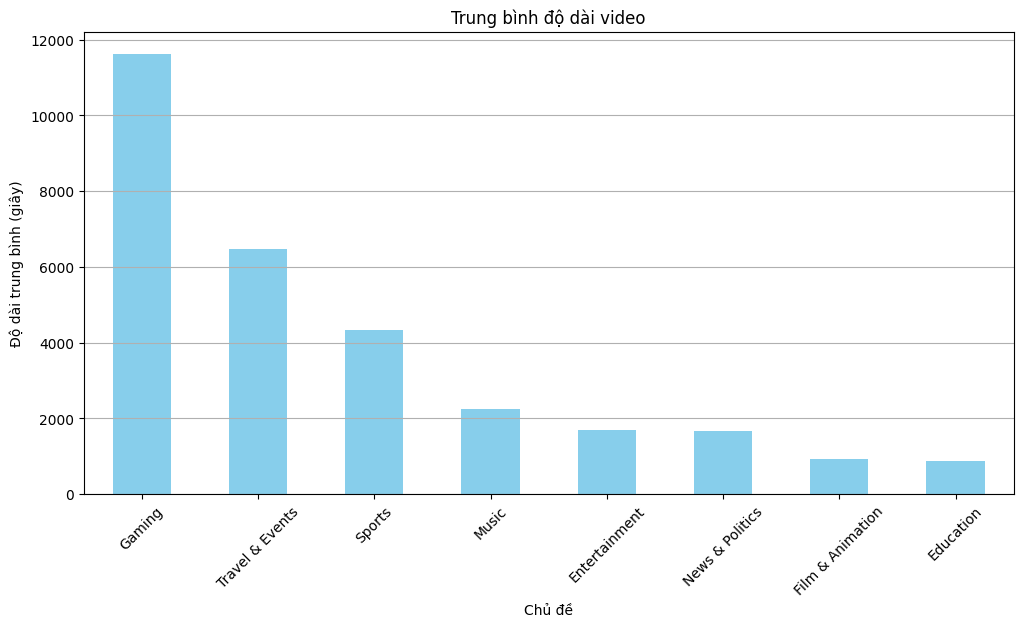

In [148]:
avg_duration_per_category = trending_videos.groupby('category')['duration'].mean()
top_10_categories = avg_duration_per_category.nlargest(8)
plt.figure(figsize=(12, 6))
top_10_categories.plot(kind='bar', color='skyblue')
plt.title('Trung bình độ dài video')
plt.xlabel('Chủ đề')
plt.ylabel('Độ dài trung bình (giây)')
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.show()

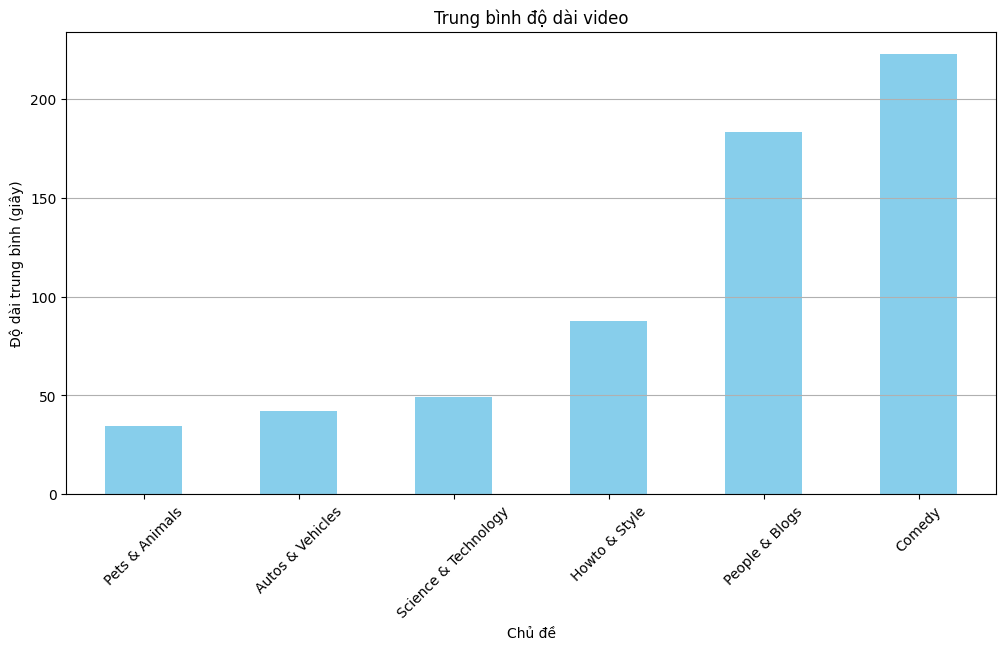

In [149]:
avg_duration_per_category = trending_videos.groupby('category')['duration'].mean()
top_10_categories = avg_duration_per_category.nsmallest(6)
plt.figure(figsize=(12, 6))
top_10_categories.plot(kind='bar', color='skyblue')
plt.title('Trung bình độ dài video')
plt.xlabel('Chủ đề')
plt.ylabel('Độ dài trung bình (giây)')
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.show()

##### b. Phần trăm của từng chủ đề trên trending

In [150]:
trending_videos = pd.read_csv('Data/trending_videos.csv')
trending_videos = trending_videos[['snapshot_date', 'category']]
trending_videos['category'] = trending_videos['category'].fillna('Unknown')
category_counts = trending_videos['category'].value_counts()
trending_videos['category'] = trending_videos['category'].apply(lambda x: x if category_counts[x] >= 400 else 'Others')
trending_videos = trending_videos.groupby(['snapshot_date', 'category']).size().unstack(fill_value=0)
trending_videos.index = pd.to_datetime(trending_videos.index)
trending_videos['month'] = trending_videos.index.to_period('M')
monthly_data = trending_videos.groupby('month').sum()

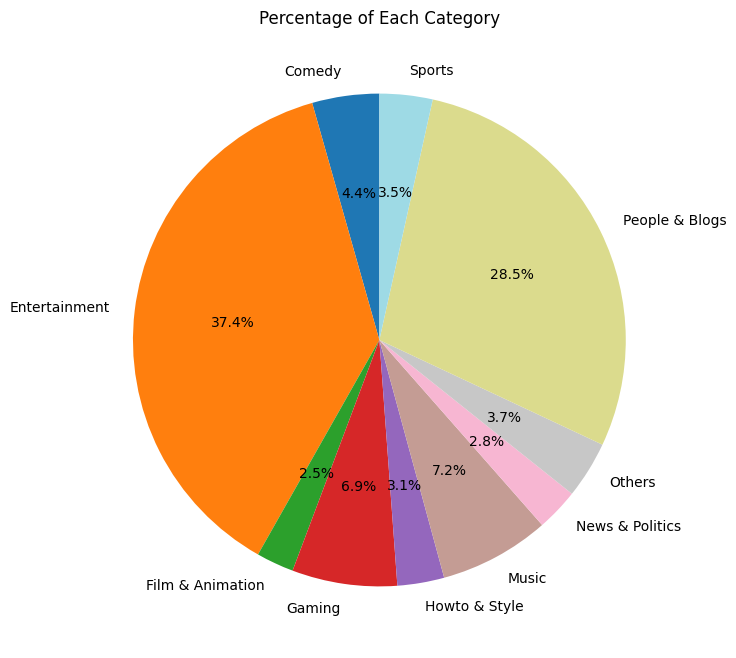

In [151]:
category_percentage = monthly_data.sum().div(monthly_data.sum().sum()) * 100
plt.figure(figsize=(10, 8))
category_percentage.plot(kind='pie', autopct='%1.1f%%', startangle=90, cmap='tab20')
plt.title('Percentage of Each Category')
plt.ylabel('')
plt.show()

##### c. Trung bình lượt tương tác theo chủ đề

In [152]:
trending_videos = pd.read_csv('Data/trending_videos.csv')
avg_views_likes_comments = trending_videos.loc[::, ["category", "view_count", "like_count", "comment_count"]]

# avg_views_likes_comments['category'] = pd.to_datetime(avg_views_likes_comments['category'])
# avg_views_likes_comments['category'] = avg_views_likes_comments['category'].dt.to_period('M')
avg_views_likes_comments = avg_views_likes_comments.groupby('category').mean().reset_index()

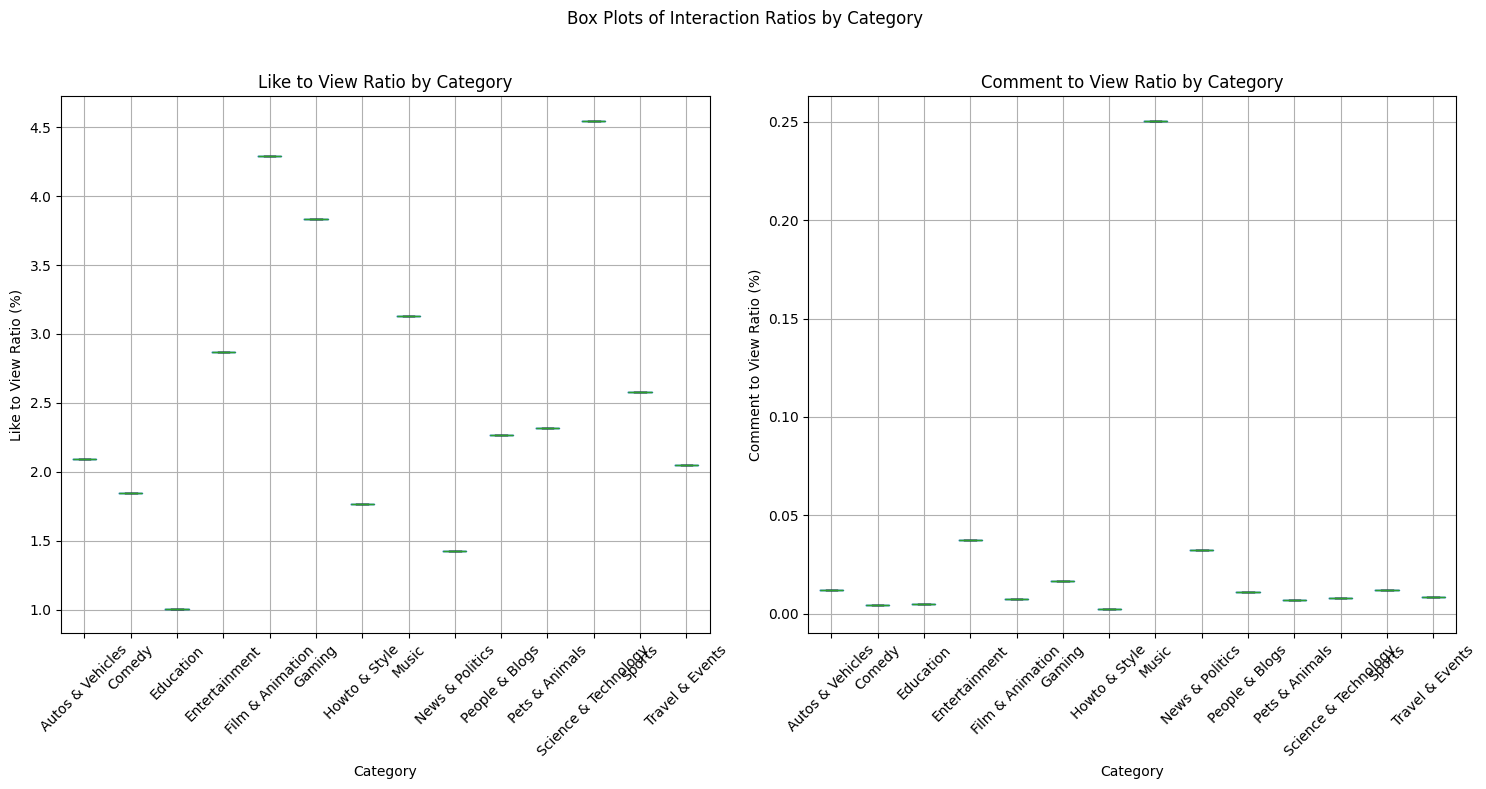

In [153]:
# Create a box plot for like_to_view and comment_to_view ratios by category
avg_views_likes_comments['like_to_view'] = (avg_views_likes_comments['like_count'] / avg_views_likes_comments['view_count']) * 100
avg_views_likes_comments['comment_to_view'] = (avg_views_likes_comments['comment_count'] / avg_views_likes_comments['view_count']) * 100

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))

# Box plot for like_to_view ratio
avg_views_likes_comments.boxplot(column='like_to_view', by='category', ax=axes[0])
axes[0].set_title('Like to View Ratio by Category')
axes[0].set_xlabel('Category')
axes[0].set_ylabel('Like to View Ratio (%)')
axes[0].tick_params(axis='x', rotation=45)

# Box plot for comment_to_view ratio
avg_views_likes_comments.boxplot(column='comment_to_view', by='category', ax=axes[1])
axes[1].set_title('Comment to View Ratio by Category')
axes[1].set_xlabel('Category')
axes[1].set_ylabel('Comment to View Ratio (%)')
axes[1].tick_params(axis='x', rotation=45)

# Adjust layout and show plot
plt.suptitle('Box Plots of Interaction Ratios by Category')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

##### d. Thời gian trending trung bình của chủ đề

In [154]:
trending_videos = pd.read_csv('Data/trending_videos_unique.csv')

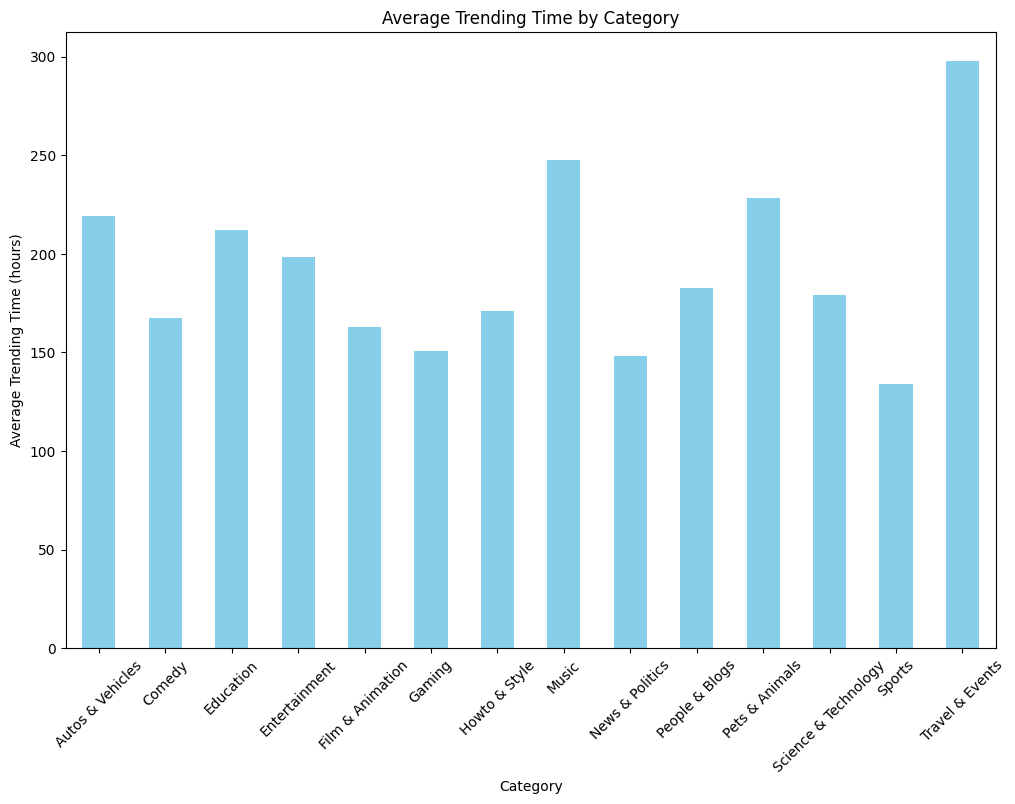

In [155]:
# Convert 'time_to_trending' to timedelta
trending_videos['trending_time'] = pd.to_timedelta(trending_videos['trending_time'])

# Calculate the average trending time for each category
avg_trending_time = trending_videos.groupby('category')['trending_time'].mean()

# Convert the average trending time to hours for better readability
avg_trending_time_hours = avg_trending_time / np.timedelta64(1, 'h')

# Plot the average trending time
plt.figure(figsize=(12, 8))
avg_trending_time_hours.plot(kind='bar', color='skyblue')
plt.title('Average Trending Time by Category')
plt.xlabel('Category')
plt.ylabel('Average Trending Time (hours)')
plt.xticks(rotation=45)
plt.show()

#### 3. Phân tích theo nội dung chi tiết

In [156]:
trending_videos_unique = pd.read_csv('Data/trending_videos_unique.csv',index_col=False)

##### a. Từ khoá trong tag

<Axes: ylabel='tag'>

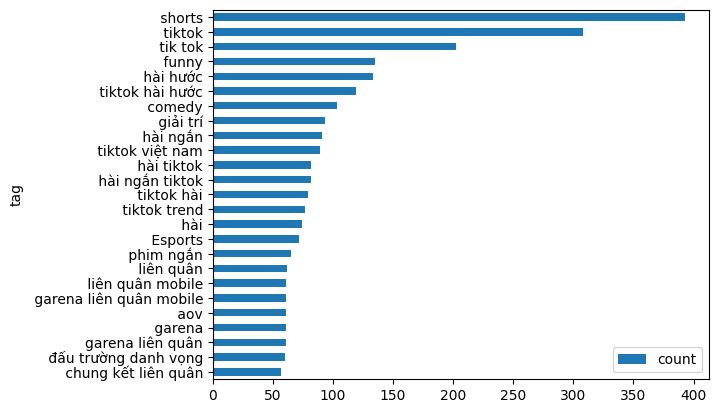

In [157]:
video_tags = trending_videos_unique.loc[::,'video_tags']
video_tags = video_tags.dropna()
tags_list = []
for tagline in video_tags:
    tags_list.extend(tagline.split(','))
count_tags = Counter(tags_list)
tags_df = pd.DataFrame(count_tags.items(),columns=['tag','count'])
tags_df_sort = tags_df.sort_values('count',ascending=True)
tags_df_sort.tail(25).set_index('tag').plot(kind='barh')

##### b. Độ dài tiêu đề

<Axes: xlabel='len'>

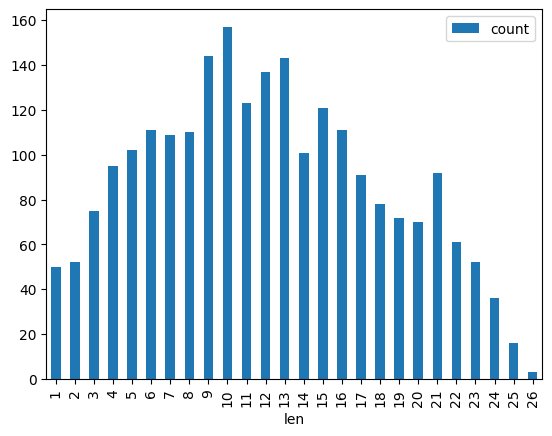

In [158]:
titles = trending_videos_unique['title']
def clean_title(title):
    return re.sub(r'[^\w\s]', '', title, flags=re.UNICODE)
def get_len_title(title):
    title = title.strip()
    return len(title.split(' '))
cleaned_title = titles.apply(clean_title)
len_titles = cleaned_title.apply(get_len_title)
count_len = Counter(len_titles)
len_df = pd.DataFrame(count_len.items(),columns=['len','count'])
len_df_to_plot = len_df.set_index('len').sort_values('len',ascending=True)
len_df_to_plot.plot(kind='bar')


#### 4. Phân tích theo thời gian

##### a. Độ dài video theo thời gian

In [159]:
trending_videos = pd.read_csv('Data/trending_videos.csv')

In [160]:
trending_videos['snapshot_date'] = pd.to_datetime(trending_videos['snapshot_date'])
trending_videos['month_year'] = trending_videos['snapshot_date'].dt.to_period('M')
trending_videos['duration'] = pd.to_timedelta(trending_videos['duration'])
bins = [pd.Timedelta(minutes=0), pd.Timedelta(minutes=1), pd.Timedelta(minutes=10), pd.Timedelta(minutes=60), pd.Timedelta(hours=24)]
labels = ['<1p', '1-10p', '10-60p', '>60p']
trending_videos['duration_category'] = pd.cut(trending_videos['duration'], bins=bins, labels=labels, right=False)
duration_df = trending_videos.groupby(['month_year', 'duration_category'], observed=False).size().unstack(fill_value=0)
duration_percentage = duration_df.div(duration_df.sum(axis=1), axis=0) * 100

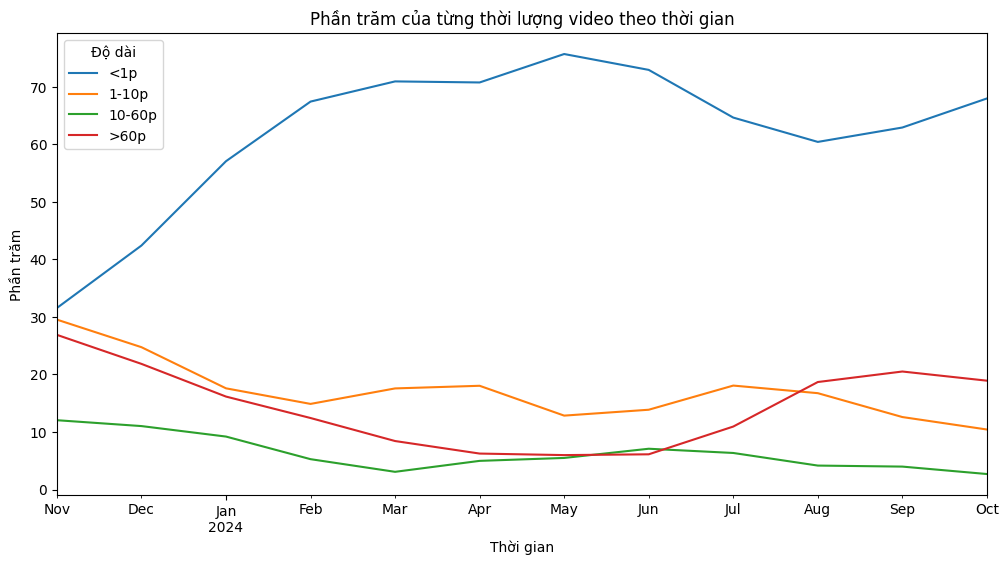

In [161]:
smoothed_duration_percentage = duration_percentage.rolling(window=2, min_periods=1).mean()
smoothed_duration_percentage.plot(kind='line', figsize=(12, 6))
plt.title('Phần trăm của từng thời lượng video theo thời gian')
plt.xlabel('Thời gian')
plt.ylabel('Phần trăm')
plt.legend(title='Độ dài')
plt.show()

##### b. Chủ đề theo thời gian

##### c. Trung bình tương tác theo thời gian